# Testes de diferentes classificadores - INFECTION

# OCPC Classifier

In [8]:
import pandas as pd
import numpy as np
import joblib 
import os
import cv2
import time
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
from ocpc_py import MultiClassPC
from codecarbon import EmissionsTracker

# Configurações
base_path = "infection/"
image_size = (64, 64)

# Monta dataset
dataset = []
for classe, label in zip(["Aug-Positive", "Aug-Negative"], [1, 0]):
    pasta = os.path.join(base_path, classe)
    for imagem in os.listdir(pasta):
        caminho_imagem = os.path.join(pasta, imagem)
        dataset.append((caminho_imagem, label))

df = pd.DataFrame(dataset, columns=["imagem", "label"])

# Carrega e normaliza imagens
def load_images(df, image_size):
    imagens, labels = [], []
    for _, row in df.iterrows():
        img = cv2.imread(row["imagem"])
        if img is not None:
            img = cv2.resize(img, image_size)
            img = img.astype("float32") / 255.0
            imagens.append(img.flatten())
            labels.append(row["label"])
        else:
            print(f"Imagem não carregada: {row['imagem']}")
    return np.array(imagens), np.array(labels)

X_all, y_all = load_images(df, image_size)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s, aucs = [], [], [], [], []

print("\n[Validação Cruzada - Treinamento]")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    pca = PCA(n_components=50)
    X_tr_pca = pca.fit_transform(X_tr)
    X_val_pca = pca.transform(X_val)

    clf = MultiClassPC()
    clf.fit(X_tr_pca, y_tr)
    y_pred = clf.predict(X_val_pca)
    y_proba = clf.predict_proba(X_val_pca)[:, 1]

    accs.append(accuracy_score(y_val, y_pred))
    precs.append(precision_score(y_val, y_pred))
    recs.append(recall_score(y_val, y_pred))
    f1s.append(f1_score(y_val, y_pred))
    aucs.append(roc_auc_score(y_val, y_proba))

    print(f"\n[Fold {fold}]")
    print(f"Acurácia: {accs[-1]:.4f} | Precisão: {precs[-1]:.4f} | Recall: {recs[-1]:.4f} | F1: {f1s[-1]:.4f} | AUC: {aucs[-1]:.4f}")

# Resultados finais do K-Fold
print("\n[Métricas Médias - Cross-Validation]")
print(f"Acurácia: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precisão: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Recall:   {np.mean(recs):.4f} ± {np.std(recs):.4f}")
print(f"F1-Score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"AUC:      {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

# TREINAMENTO FINAL PARA PRODUÇÃO
print("\n[Treinamento Final e Avaliação em Teste]")
tracker = EmissionsTracker(log_level="ERROR")  # Desabilitar logs detalhados
tracker.start()

pca_final = PCA(n_components=50)
X_train_pca = pca_final.fit_transform(X_train)
X_test_pca = pca_final.transform(X_test)

clf_final = MultiClassPC()
clf_final.fit(X_train_pca, y_train)

emissions = tracker.stop()
print(f"\n[Pegada de Carbono]")
print(f"Emissões estimadas durante todo o experimento: {emissions:.6f} kg CO₂eq")

# Avaliação no conjunto de teste
y_pred_test = clf_final.predict(X_test_pca)
y_proba_test = clf_final.predict_proba(X_test_pca)[:, 1]

print("\n[Desempenho no Conjunto de Teste]")
print(f"Acurácia: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall:   {recall_score(y_test, y_pred_test):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
print(f"AUC:      {roc_auc_score(y_test, y_proba_test):.4f}")
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_test))

# Medindo tempo de classificação (inference time)
tempos_inferencia = []
for x in X_test_pca:
    inicio = time.time()
    _ = clf_final.predict(x.reshape(1, -1))
    fim = time.time()
    tempos_inferencia.append(fim - inicio)

tempos_inferencia = np.array(tempos_inferencia)
print("\n[TEMPO DE CLASSIFICAÇÃO]")
print(f"Tempo médio por imagem: {np.mean(tempos_inferencia):.6f} s ± {np.std(tempos_inferencia):.6f} s")

output_dir = "Models/INFECTION"
os.makedirs(output_dir, exist_ok=True)
pca_path = os.path.join(output_dir, "OCPC_pca_infection.pkl")
clf_path = os.path.join(output_dir, "OCPC_modelo_infection.pkl")
joblib.dump(pca_final, pca_path)
joblib.dump(clf_final, clf_path)


[Validação Cruzada - Treinamento]

[Fold 1]
Acurácia: 0.5440 | Precisão: 0.5436 | Recall: 0.4569 | F1: 0.4965 | AUC: 0.5713

[Fold 2]
Acurácia: 0.5536 | Precisão: 0.5584 | Recall: 0.5169 | F1: 0.5369 | AUC: 0.5796

[Fold 3]
Acurácia: 0.5287 | Precisão: 0.5092 | Recall: 0.4912 | F1: 0.5000 | AUC: 0.5441

[Fold 4]
Acurácia: 0.5329 | Precisão: 0.5446 | Recall: 0.5083 | F1: 0.5259 | AUC: 0.5371

[Fold 5]
Acurácia: 0.5658 | Precisão: 0.5971 | Recall: 0.4980 | F1: 0.5430 | AUC: 0.5995

[Métricas Médias - Cross-Validation]
Acurácia: 0.5450 ± 0.0136
Precisão: 0.5506 ± 0.0283
Recall:   0.4943 ± 0.0207
F1-Score: 0.5204 ± 0.0190
AUC:      0.5663 ± 0.0231

[Treinamento Final e Avaliação em Teste]

[Pegada de Carbono]
Emissões estimadas durante todo o experimento: 0.000007 kg CO₂eq

[Desempenho no Conjunto de Teste]
Acurácia: 0.5526
Precisão: 0.5572
Recall:   0.5127
F1-Score: 0.5340
AUC:      0.5849
Matriz de Confusão:
[[349 240]
 [287 302]]

[TEMPO DE CLASSIFICAÇÃO]
Tempo médio por imagem: 0.0010

['Models/INFECTION\\OCPC_modelo_infection.pkl']

# Random Forest

## Random Forest sem PCA

In [3]:
import pandas as pd
import numpy as np
import os
import cv2
import time
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
import joblib
from codecarbon import EmissionsTracker 

# Caminho base e configuração
base_path = "infection/"
image_size = (64, 64)

# Montar dataset (imagem, rótulo)
dataset = []
for classe, label in zip(["Aug-Positive", "Aug-Negative"], [1, 0]):
    pasta = os.path.join(base_path, classe)
    for imagem in os.listdir(pasta):
        caminho_imagem = os.path.join(pasta, imagem)
        dataset.append((caminho_imagem, label))
df = pd.DataFrame(dataset, columns=["imagem", "label"])

# Carregar e normalizar imagens
def load_images(df, image_size):
    imagens, labels = [], []
    for _, row in df.iterrows():
        img = cv2.imread(row["imagem"])
        if img is not None:
            img = cv2.resize(img, image_size)
            img = img.astype("float32") / 255.0
            imagens.append(img.flatten())
            labels.append(row["label"])
        else:
            print(f"Imagem não carregada: {row['imagem']}")
    return np.array(imagens), np.array(labels)

X_all, y_all = load_images(df, image_size)

# Separar treino/teste (20% é o holdout final)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# VALIDAÇÃO CRUZADA (K-Fold no treino)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s, aucs = [], [], [], [], []

print("\n[Cross Validation - Treinamento]")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_tr, y_tr)

    y_pred = clf.predict(X_val)
    y_proba = clf.predict_proba(X_val)[:, 1]

    accs.append(accuracy_score(y_val, y_pred))
    precs.append(precision_score(y_val, y_pred))
    recs.append(recall_score(y_val, y_pred))
    f1s.append(f1_score(y_val, y_pred))
    aucs.append(roc_auc_score(y_val, y_proba))

    print(f"\n[Fold {fold}]")
    print(f"Acurácia: {accs[-1]:.4f} | Precisão: {precs[-1]:.4f} | Recall: {recs[-1]:.4f} | F1: {f1s[-1]:.4f} | AUC: {aucs[-1]:.4f}")

# Exibir métricas médias
print("\n[Métricas Médias - Cross-Validation]")
print(f"Acurácia: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precisão: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Recall:   {np.mean(recs):.4f} ± {np.std(recs):.4f}")
print(f"F1-Score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"AUC:      {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

print("\n[Treinamento Final e Avaliação em Teste]")
tracker = EmissionsTracker(log_level="ERROR")  # Desabilitar logs detalhados
tracker.start()

clf_final = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
clf_final.fit(X_train, y_train)

emissions = tracker.stop()
print(f"\n[Pegada de Carbono]")
print(f"Emissões estimadas durante o treinamento final: {emissions:.6f} kg CO₂eq")

# Avaliação em teste
y_pred_test = clf_final.predict(X_test)
y_proba_test = clf_final.predict_proba(X_test)[:, 1]

print("\n[Desempenho no Conjunto de Teste]")
print(f"Acurácia: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall:   {recall_score(y_test, y_pred_test):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
print(f"AUC:      {roc_auc_score(y_test, y_proba_test):.4f}")
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_test))

# Medindo tempo de classificação (em segundos)
tempos_inferencia = []
for x in X_test:
    inicio = time.time()
    _ = clf_final.predict([x])
    fim = time.time()
    tempos_inferencia.append(fim - inicio)  

tempos_inferencia = np.array(tempos_inferencia)
print("\n[TEMPO DE CLASSIFICAÇÃO]")
print(f"Tempo médio por imagem: {np.mean(tempos_inferencia):.4f} s ± {np.std(tempos_inferencia):.4f} s")

#Salvando o modelo final
output_dir = "Models/INFECTION"
os.makedirs(output_dir, exist_ok=True)
clf_path = os.path.join(output_dir, "random_forest_infection.pkl")
joblib.dump(clf_final, clf_path)



[Cross Validation - Treinamento]

[Fold 1]
Acurácia: 0.7349 | Precisão: 0.7572 | Recall: 0.6789 | F1: 0.7159 | AUC: 0.8150

[Fold 2]
Acurácia: 0.7285 | Precisão: 0.7673 | Recall: 0.6568 | F1: 0.7078 | AUC: 0.8116

[Fold 3]
Acurácia: 0.7569 | Precisão: 0.7551 | Recall: 0.7301 | F1: 0.7424 | AUC: 0.8293

[Fold 4]
Acurácia: 0.7399 | Precisão: 0.7652 | Recall: 0.7063 | F1: 0.7346 | AUC: 0.7982

[Fold 5]
Acurácia: 0.7208 | Precisão: 0.7598 | Recall: 0.6742 | F1: 0.7144 | AUC: 0.8149

[Métricas Médias - Cross-Validation]
Acurácia: 0.7362 ± 0.0122
Precisão: 0.7609 ± 0.0046
Recall:   0.6892 ± 0.0259
F1-Score: 0.7230 ± 0.0132
AUC:      0.8138 ± 0.0099

[Treinamento Final e Avaliação em Teste]

[Pegada de Carbono]
Emissões estimadas durante o treinamento final: 0.000021 kg CO₂eq

[Desempenho no Conjunto de Teste]
Acurácia: 0.7402
Precisão: 0.7737
Recall:   0.6791
F1-Score: 0.7233
AUC:      0.8198
Matriz de Confusão:
[[472 117]
 [189 400]]

[TEMPO DE CLASSIFICAÇÃO]
Tempo médio por imagem: 0.0392

['Models/INFECTION\\random_forest_infection.pkl']

## Random Forest com PCA


In [13]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier
from codecarbon import EmissionsTracker 
import joblib

# Configurações
base_path = "infection/"
image_size = (64, 64)

# Monta dataset
dataset = []
for classe, label in zip(["Aug-Positive", "Aug-Negative"], [1, 0]):
    pasta = os.path.join(base_path, classe)
    for imagem in os.listdir(pasta):
        caminho_imagem = os.path.join(pasta, imagem)
        dataset.append((caminho_imagem, label))

df = pd.DataFrame(dataset, columns=["imagem", "label"])

# Carrega e normaliza imagens
def load_images(df, image_size):
    imagens, labels = [], []
    for _, row in df.iterrows():
        img = cv2.imread(row["imagem"])
        if img is not None:
            img = cv2.resize(img, image_size)
            img = img.astype("float32") / 255.0
            imagens.append(img.flatten())
            labels.append(row["label"])
        else:
            print(f"Imagem não carregada: {row['imagem']}")
    return np.array(imagens), np.array(labels)

X_all, y_all = load_images(df, image_size)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s, aucs = [], [], [], [], []

print("\n[Validação Cruzada - Treinamento]")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    pca = PCA(n_components=50)
    X_tr_pca = pca.fit_transform(X_tr)
    X_val_pca = pca.transform(X_val)

    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_tr_pca, y_tr)
    y_pred = clf.predict(X_val_pca)
    y_proba = clf.predict_proba(X_val_pca)[:, 1]

    accs.append(accuracy_score(y_val, y_pred))
    precs.append(precision_score(y_val, y_pred))
    recs.append(recall_score(y_val, y_pred))
    f1s.append(f1_score(y_val, y_pred))
    aucs.append(roc_auc_score(y_val, y_proba))

    print(f"\n[Fold {fold}]")
    print(f"Acurácia: {accs[-1]:.4f} | Precisão: {precs[-1]:.4f} | Recall: {recs[-1]:.4f} | F1: {f1s[-1]:.4f} | AUC: {aucs[-1]:.4f}")

# Resultados finais do K-Fold
print("\n[Métricas Médias - Cross-Validation]")
print(f"Acurácia: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precisão: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Recall:   {np.mean(recs):.4f} ± {np.std(recs):.4f}")
print(f"F1-Score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"AUC:      {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

# TREINAMENTO FINAL PARA PRODUÇÃO
print("\n[Treinamento Final e Avaliação em Teste]")
tracker = EmissionsTracker(log_level="ERROR")  # Desabilitar logs detalhados
tracker.start()

pca_final = PCA(n_components=50)
X_train_pca = pca_final.fit_transform(X_train)
X_test_pca = pca_final.transform(X_test)

clf_final = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
clf_final.fit(X_train_pca, y_train)

emissions = tracker.stop()
print(f"\n[Pegada de Carbono]")
print(f"Emissões estimadas durante o treinamento final: {emissions:.6f} kg CO₂eq")

# Avaliação no conjunto de teste
y_pred_test = clf_final.predict(X_test_pca)
y_proba_test = clf_final.predict_proba(X_test_pca)[:, 1]

print("\n[Desempenho no Conjunto de Teste]")
print(f"Acurácia: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall:   {recall_score(y_test, y_pred_test):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
print(f"AUC:      {roc_auc_score(y_test, y_proba_test):.4f}")
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_test))

# Medindo tempo de classificação (em segundos)
tempos_inferencia = []
for x in X_test_pca:
    inicio = time.time()
    _ = clf_final.predict([x])
    fim = time.time()
    tempos_inferencia.append(fim - inicio)  

tempos_inferencia = np.array(tempos_inferencia)
print("\n[TEMPO DE CLASSIFICAÇÃO]")
print(f"Tempo médio por imagem: {np.mean(tempos_inferencia):.4f} s ± {np.std(tempos_inferencia):.4f} s")

output_dir = "Models/INFECTION"
os.makedirs(output_dir, exist_ok=True)
pca_path = os.path.join(output_dir, "random_forest_PCA_infection.pkl")
clf_path = os.path.join(output_dir, "random_forest_modelo_PCA_infection.pkl")
joblib.dump(pca_final, pca_path)
joblib.dump(clf_final, clf_path)



[Validação Cruzada - Treinamento]

[Fold 1]
Acurácia: 0.6840 | Precisão: 0.6701 | Recall: 0.7047 | F1: 0.6870 | AUC: 0.7687

[Fold 2]
Acurácia: 0.7137 | Precisão: 0.7131 | Recall: 0.7161 | F1: 0.7146 | AUC: 0.7765

[Fold 3]
Acurácia: 0.7134 | Precisão: 0.6777 | Recall: 0.7677 | F1: 0.7199 | AUC: 0.7835

[Fold 4]
Acurácia: 0.6868 | Precisão: 0.6796 | Recall: 0.7292 | F1: 0.7035 | AUC: 0.7619

[Fold 5]
Acurácia: 0.6943 | Precisão: 0.6938 | Recall: 0.7336 | F1: 0.7131 | AUC: 0.7727

[Métricas Médias - Cross-Validation]
Acurácia: 0.6984 ± 0.0128
Precisão: 0.6869 ± 0.0152
Recall:   0.7303 ± 0.0213
F1-Score: 0.7076 ± 0.0116
AUC:      0.7726 ± 0.0073

[Treinamento Final e Avaliação em Teste]

[Pegada de Carbono]
Emissões estimadas durante o treinamento final: 0.000008 kg CO₂eq

[Desempenho no Conjunto de Teste]
Acurácia: 0.7029
Precisão: 0.6918
Recall:   0.7317
F1-Score: 0.7112
AUC:      0.7875
Matriz de Confusão:
[[397 192]
 [158 431]]

[TEMPO DE CLASSIFICAÇÃO]
Tempo médio por imagem: 0.043

['Models/INFECTION\\random_forest_modelo_PCA_infection.pkl']

# XGBOOST

## XGBOOST com PCA

In [9]:
import pandas as pd
import numpy as np
import os
import cv2
import joblib
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
from xgboost import XGBClassifier
from codecarbon import EmissionsTracker 

base_path = "infection/"
image_size = (64, 64)

# Monta dataset
dataset = []
for classe, label in zip(["Aug-Positive", "Aug-Negative"], [1, 0]):
    pasta = os.path.join(base_path, classe)
    for imagem in os.listdir(pasta):
        caminho_imagem = os.path.join(pasta, imagem)
        dataset.append((caminho_imagem, label))

df = pd.DataFrame(dataset, columns=["imagem", "label"])

# Carrega e normaliza imagens
def load_images(df, image_size):
    imagens, labels = [], []
    for _, row in df.iterrows():
        img = cv2.imread(row["imagem"])
        if img is not None:
            img = cv2.resize(img, image_size)
            img = img.astype("float32") / 255.0
            imagens.append(img.flatten())
            labels.append(row["label"])
        else:
            print(f"[AVISO] Imagem não carregada: {row['imagem']}")
    return np.array(imagens), np.array(labels)

X_all, y_all = load_images(df, image_size)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s, aucs = [], [], [], [], []

print("\n[Validação Cruzada - Treinamento]")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    pca = PCA(n_components=50)
    X_tr_pca = pca.fit_transform(X_tr)
    X_val_pca = pca.transform(X_val)

    clf = XGBClassifier(
        n_estimators=300, max_depth=8, learning_rate=0.1,
        use_label_encoder=False, eval_metric='logloss',
        scale_pos_weight=1, random_state=42, n_jobs=-1
    )
    clf.fit(X_tr_pca, y_tr)
    y_pred = clf.predict(X_val_pca)
    y_proba = clf.predict_proba(X_val_pca)[:, 1]

    accs.append(accuracy_score(y_val, y_pred))
    precs.append(precision_score(y_val, y_pred))
    recs.append(recall_score(y_val, y_pred))
    f1s.append(f1_score(y_val, y_pred))
    aucs.append(roc_auc_score(y_val, y_proba))

    print(f"\n[Fold {fold}]")
    print(f"Acurácia: {accs[-1]:.4f} | Precisão: {precs[-1]:.4f} | Recall: {recs[-1]:.4f} | F1: {f1s[-1]:.4f} | AUC: {aucs[-1]:.4f}")

# Resultados finais do K-Fold
print("\n[Métricas Médias - Cross-Validation]")
print(f"Acurácia: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precisão: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Recall:   {np.mean(recs):.4f} ± {np.std(recs):.4f}")
print(f"F1-Score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"AUC:      {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

# TREINAMENTO FINAL PARA PRODUÇÃO
print("\n[Treinamento Final e Avaliação em Teste]")
tracker = EmissionsTracker(log_level="ERROR")  # Desabilitar logs detalhados
tracker.start()

pca_final = PCA(n_components=50)
X_train_pca = pca_final.fit_transform(X_train)
X_test_pca = pca_final.transform(X_test)

clf_final = XGBClassifier(
        n_estimators=300, max_depth=8, learning_rate=0.1,
        use_label_encoder=False, eval_metric='logloss',
        scale_pos_weight=1, random_state=42, n_jobs=-1
    )
clf_final.fit(X_train_pca, y_train)

emissions = tracker.stop()
print(f"\n[Pegada de Carbono]")
print(f"Emissões estimadas durante o treinamento final: {emissions:.6f} kg CO₂eq")

# Avaliação no conjunto de teste
y_pred_test = clf_final.predict(X_test_pca)
y_proba_test = clf_final.predict_proba(X_test_pca)[:, 1]

print("\n[Desempenho no Conjunto de Teste]")
print(f"Acurácia: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall:   {recall_score(y_test, y_pred_test):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
print(f"AUC:      {roc_auc_score(y_test, y_proba_test):.4f}")
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_test))

# Medindo tempo de classificação (em segundos)
tempos_inferencia = []
for x in X_test_pca:
    inicio = time.time()
    _ = clf_final.predict([x])
    fim = time.time()
    tempos_inferencia.append(fim - inicio)  

tempos_inferencia = np.array(tempos_inferencia)
print("\n[TEMPO DE CLASSIFICAÇÃO]")
print(f"Tempo médio por imagem: {np.mean(tempos_inferencia):.4f} s ± {np.std(tempos_inferencia):.4f} s")

output_dir = "Models/INFECTION"
os.makedirs(output_dir, exist_ok=True)
pca_path = os.path.join(output_dir, "XGB_PCA_infection.pkl")
clf_path = os.path.join(output_dir, "XGB_modelo_PCA_infection.pkl")
joblib.dump(pca_final, pca_path)
joblib.dump(clf_final, clf_path)



[Validação Cruzada - Treinamento]

[Fold 1]
Acurácia: 0.7116 | Precisão: 0.7078 | Recall: 0.7047 | F1: 0.7063 | AUC: 0.7818

[Fold 2]
Acurácia: 0.7264 | Precisão: 0.7357 | Recall: 0.7076 | F1: 0.7214 | AUC: 0.7896

[Fold 3]
Acurácia: 0.7208 | Precisão: 0.6901 | Recall: 0.7588 | F1: 0.7229 | AUC: 0.8020

[Fold 4]
Acurácia: 0.7070 | Precisão: 0.7082 | Recall: 0.7229 | F1: 0.7155 | AUC: 0.7737

[Fold 5]
Acurácia: 0.7208 | Precisão: 0.7339 | Recall: 0.7234 | F1: 0.7286 | AUC: 0.7953

[Métricas Médias - Cross-Validation]
Acurácia: 0.7173 ± 0.0070
Precisão: 0.7151 ± 0.0173
Recall:   0.7235 ± 0.0193
F1-Score: 0.7189 ± 0.0076
AUC:      0.7885 ± 0.0099

[Treinamento Final e Avaliação em Teste]

[Pegada de Carbono]
Emissões estimadas durante o treinamento final: 0.000006 kg CO₂eq

[Desempenho no Conjunto de Teste]
Acurácia: 0.7080
Precisão: 0.7138
Recall:   0.6944
F1-Score: 0.7040
AUC:      0.7930
Matriz de Confusão:
[[425 164]
 [180 409]]

[TEMPO DE CLASSIFICAÇÃO]
Tempo médio por imagem: 0.000

['Models/INFECTION\\XGB_modelo_PCA_infection.pkl']

## XGBOOST sem PCA


[Cross Validation - Treinamento]

[Fold 1]
Acurácia: 0.7635 | Precisão: 0.7796 | Recall: 0.7241 | F1: 0.7508 | AUC: 0.8338

[Fold 2]
Acurácia: 0.7413 | Precisão: 0.7780 | Recall: 0.6758 | F1: 0.7234 | AUC: 0.8303

[Fold 3]
Acurácia: 0.7707 | Precisão: 0.7706 | Recall: 0.7434 | F1: 0.7568 | AUC: 0.8485

[Fold 4]
Acurácia: 0.7293 | Precisão: 0.7517 | Recall: 0.7000 | F1: 0.7249 | AUC: 0.8195


[codecarbon WARNING @ 10:01:02] Multiple instances of codecarbon are allowed to run at the same time.



[Fold 5]
Acurácia: 0.7452 | Precisão: 0.7707 | Recall: 0.7234 | F1: 0.7463 | AUC: 0.8352

[Métricas Médias - Cross-Validation]
Acurácia: 0.7500 ± 0.0151
Precisão: 0.7701 ± 0.0099
Recall:   0.7133 ± 0.0232
F1-Score: 0.7404 ± 0.0137
AUC:      0.8335 ± 0.0093

[Treinamento Final e Avaliação em Teste]

[Pegada de Carbono]
Emissões estimadas durante o treinamento final: 0.000271 kg CO₂eq

[Desempenho no Conjunto de Teste]
Acurácia: 0.7547
Precisão: 0.7820
Recall:   0.7063
F1-Score: 0.7422
AUC:      0.8446
Matriz de Confusão:
[[473 116]
 [173 416]]


NameError: name 'output_dir' is not defined

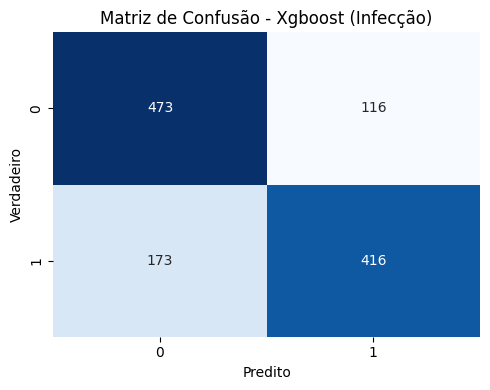

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
from xgboost import XGBClassifier
from codecarbon import EmissionsTracker 

# Caminho base e configurações
base_path = "infection/"
image_size = (32, 32)

# Montar dataframe com caminhos e rótulos
dataset = []
for classe, label in zip(["Aug-Positive", "Aug-Negative"], [1, 0]):
    pasta = os.path.join(base_path, classe)
    for imagem in os.listdir(pasta):
        dataset.append((os.path.join(pasta, imagem), label))
df = pd.DataFrame(dataset, columns=["imagem", "label"])

# Função para carregar imagens
def load_images(df, image_size):
    imagens, labels = [], []
    for _, row in df.iterrows():
        img = cv2.imread(row["imagem"])
        if img is not None:
            img = cv2.resize(img, image_size)
            img = img.astype("float32") / 255.0
            imagens.append(img.flatten())
            labels.append(row["label"])
        else:
            print(f"[AVISO] Imagem não carregada: {row['imagem']}")
    return np.array(imagens), np.array(labels)

X_all, y_all = load_images(df, image_size)

# Separar treino/teste (20% é o holdout final)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# VALIDAÇÃO CRUZADA (K-Fold no treino)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s, aucs = [], [], [], [], []

print("\n[Cross Validation - Treinamento]")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    clf = XGBClassifier(
        n_estimators=300, max_depth=8, learning_rate=0.1,
        use_label_encoder=False, eval_metric='logloss',
        scale_pos_weight=1, random_state=42, n_jobs=-1
    )
    clf.fit(X_tr, y_tr)

    y_pred = clf.predict(X_val)
    y_proba = clf.predict_proba(X_val)[:, 1]

    accs.append(accuracy_score(y_val, y_pred))
    precs.append(precision_score(y_val, y_pred))
    recs.append(recall_score(y_val, y_pred))
    f1s.append(f1_score(y_val, y_pred))
    aucs.append(roc_auc_score(y_val, y_proba))

    print(f"\n[Fold {fold}]")
    print(f"Acurácia: {accs[-1]:.4f} | Precisão: {precs[-1]:.4f} | Recall: {recs[-1]:.4f} | F1: {f1s[-1]:.4f} | AUC: {aucs[-1]:.4f}")

# Exibir métricas médias
print("\n[Métricas Médias - Cross-Validation]")
print(f"Acurácia: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precisão: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Recall:   {np.mean(recs):.4f} ± {np.std(recs):.4f}")
print(f"F1-Score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"AUC:      {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

print("\n[Treinamento Final e Avaliação em Teste]")
tracker = EmissionsTracker(log_level="ERROR")  # Desabilitar logs detalhados
tracker.start()

clf_final = XGBClassifier(
    n_estimators=300, max_depth=8, learning_rate=0.1,
    use_label_encoder=False, eval_metric='logloss',
    scale_pos_weight=1, random_state=42, n_jobs=-1
)
clf_final.fit(X_train, y_train)

emissions = tracker.stop()
print(f"\n[Pegada de Carbono]")
print(f"Emissões estimadas durante o treinamento final: {emissions:.6f} kg CO₂eq")

# Avaliação em teste
y_pred_test = clf_final.predict(X_test)
y_proba_test = clf_final.predict_proba(X_test)[:, 1]

print("\n[Desempenho no Conjunto de Teste]")
print(f"Acurácia: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall:   {recall_score(y_test, y_pred_test):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
print(f"AUC:      {roc_auc_score(y_test, y_proba_test):.4f}")
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_test))

# Gerar e plotar matriz de confusão
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matriz de Confusão - Xgboost (Infecção)")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.tight_layout()
plt.show()

# Medindo tempo de classificação (em segundos)
import time
tempos_inferencia = []
for x in X_test:
    inicio = time.time()
    _ = clf_final.predict([x])
    fim = time.time()
    tempos_inferencia.append(fim - inicio)  

tempos_inferencia = np.array(tempos_inferencia)
print("\n[TEMPO DE CLASSIFICAÇÃO]")
print(f"Tempo médio por imagem: {np.mean(tempos_inferencia):.4f} s ± {np.std(tempos_inferencia):.4f} s")

output_dir = "Models/INFECTION"
os.makedirs(output_dir, exist_ok=True)
clf_path = os.path.join(output_dir, "XGB_infection.pkl")
joblib.dump(clf_final, clf_path)


# MLPClassifier

## MLPClassifier com PCA

In [11]:
import pandas as pd
import numpy as np
import os
import cv2
import joblib
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
from sklearn.neural_network import MLPClassifier
from codecarbon import EmissionsTracker 

# Configurações
base_path = "infection/"
image_size = (64, 64)

# Monta dataset
dataset = []
for classe, label in zip(["Aug-Positive", "Aug-Negative"], [1, 0]):
    pasta = os.path.join(base_path, classe)
    for imagem in os.listdir(pasta):
        caminho_imagem = os.path.join(pasta, imagem)
        dataset.append((caminho_imagem, label))

df = pd.DataFrame(dataset, columns=["imagem", "label"])

# Carrega e normaliza imagens
def load_images(df, image_size):
    imagens, labels = [], []
    for _, row in df.iterrows():
        img = cv2.imread(row["imagem"])
        if img is not None:
            img = cv2.resize(img, image_size)
            img = img.astype("float32") / 255.0
            imagens.append(img.flatten())
            labels.append(row["label"])
        else:
            print(f"Imagem não carregada: {row['imagem']}")
    return np.array(imagens), np.array(labels)

X_all, y_all = load_images(df, image_size)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s, aucs = [], [], [], [], []

print("\n[Validação Cruzada - Treinamento]")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    pca = PCA(n_components=50)
    X_tr_pca = pca.fit_transform(X_tr)
    X_val_pca = pca.transform(X_val)

    clf = MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        learning_rate_init=0.001,
        max_iter=500,
        early_stopping=True,
        random_state=42
    )
    clf.fit(X_tr_pca, y_tr)
    y_pred = clf.predict(X_val_pca)
    y_proba = clf.predict_proba(X_val_pca)[:, 1]

    accs.append(accuracy_score(y_val, y_pred))
    precs.append(precision_score(y_val, y_pred))
    recs.append(recall_score(y_val, y_pred))
    f1s.append(f1_score(y_val, y_pred))
    aucs.append(roc_auc_score(y_val, y_proba))

    print(f"\n[Fold {fold}]")
    print(f"Acurácia: {accs[-1]:.4f} | Precisão: {precs[-1]:.4f} | Recall: {recs[-1]:.4f} | F1: {f1s[-1]:.4f} | AUC: {aucs[-1]:.4f}")

# Resultados finais do K-Fold
print("\n[Métricas Médias - Cross-Validation]")
print(f"Acurácia: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precisão: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Recall:   {np.mean(recs):.4f} ± {np.std(recs):.4f}")
print(f"F1-Score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"AUC:      {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

# TREINAMENTO FINAL PARA PRODUÇÃO
print("\n[Treinamento Final e Avaliação em Teste]")
tracker = EmissionsTracker(log_level="ERROR")  # Desabilitar logs detalhados
tracker.start()

pca_final = PCA(n_components=50)
X_train_pca = pca_final.fit_transform(X_train)
X_test_pca = pca_final.transform(X_test)

clf_final = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    learning_rate_init=0.001,
    max_iter=500,
    early_stopping=True,
    random_state=42
)
clf_final.fit(X_train_pca, y_train)

emissions = tracker.stop()
print(f"\n[Pegada de Carbono]")
print(f"Emissões estimadas durante o treinamento final: {emissions:.6f} kg CO₂eq")

# Avaliação no conjunto de teste
y_pred_test = clf_final.predict(X_test_pca)
y_proba_test = clf_final.predict_proba(X_test_pca)[:, 1]

print("\n[Desempenho no Conjunto de Teste]")
print(f"Acurácia: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall:   {recall_score(y_test, y_pred_test):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
print(f"AUC:      {roc_auc_score(y_test, y_proba_test):.4f}")
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_test))

# Medindo tempo de classificação (em segundos)
tempos_inferencia = []
import time
for x in X_test_pca:
    inicio = time.time()
    _ = clf_final.predict([x])
    fim = time.time()
    tempos_inferencia.append(fim - inicio)  

tempos_inferencia = np.array(tempos_inferencia)
print("\n[TEMPO DE CLASSIFICAÇÃO]")
print(f"Tempo médio por imagem: {np.mean(tempos_inferencia):.4f} s ± {np.std(tempos_inferencia):.4f} s")

output_dir = "Models/INFECTION"
os.makedirs(output_dir, exist_ok=True)
pca_path = os.path.join(output_dir, "MLP_PCA_infection.pkl")
clf_path = os.path.join(output_dir, "MLP_modelo_PCA_infection.pkl")
joblib.dump(pca_final, pca_path)
joblib.dump(clf_final, clf_path)




[Validação Cruzada - Treinamento]

[Fold 1]
Acurácia: 0.6787 | Precisão: 0.6968 | Recall: 0.6142 | F1: 0.6529 | AUC: 0.7494

[Fold 2]
Acurácia: 0.7105 | Precisão: 0.7140 | Recall: 0.7034 | F1: 0.7086 | AUC: 0.7758

[Fold 3]
Acurácia: 0.7006 | Precisão: 0.6932 | Recall: 0.6748 | F1: 0.6839 | AUC: 0.7674

[Fold 4]
Acurácia: 0.6826 | Precisão: 0.6972 | Recall: 0.6667 | F1: 0.6816 | AUC: 0.7642

[Fold 5]
Acurácia: 0.7070 | Precisão: 0.7420 | Recall: 0.6660 | F1: 0.7019 | AUC: 0.7862

[Métricas Médias - Cross-Validation]
Acurácia: 0.6959 ± 0.0129
Precisão: 0.7086 ± 0.0182
Recall:   0.6650 ± 0.0288
F1-Score: 0.6858 ± 0.0194
AUC:      0.7686 ± 0.0123

[Treinamento Final e Avaliação em Teste]

[Pegada de Carbono]
Emissões estimadas durante o treinamento final: 0.000004 kg CO₂eq

[Desempenho no Conjunto de Teste]
Acurácia: 0.6952
Precisão: 0.6997
Recall:   0.6842
F1-Score: 0.6918
AUC:      0.7688
Matriz de Confusão:
[[416 173]
 [186 403]]

[TEMPO DE CLASSIFICAÇÃO]
Tempo médio por imagem: 0.000

['Models/INFECTION\\MLP_modelo_PCA_infection.pkl']

## MLPClassifier sem PCA

In [12]:
import pandas as pd
import numpy as np
import os
import cv2
import joblib
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
from sklearn.neural_network import MLPClassifier
from codecarbon import EmissionsTracker
import time

# Caminho base e configuração
base_path = "infection/"
image_size = (64, 64)

# Montar dataset (imagem, rótulo)
dataset = []
for classe, label in zip(["Aug-Positive", "Aug-Negative"], [1, 0]):
    pasta = os.path.join(base_path, classe)
    for imagem in os.listdir(pasta):
        caminho_imagem = os.path.join(pasta, imagem)
        dataset.append((caminho_imagem, label))
df = pd.DataFrame(dataset, columns=["imagem", "label"])

# Carregar e normalizar imagens
def load_images(df, image_size):
    imagens, labels = [], []
    for _, row in df.iterrows():
        img = cv2.imread(row["imagem"])
        if img is not None:
            img = cv2.resize(img, image_size)
            img = img.astype("float32") / 255.0
            imagens.append(img.flatten())
            labels.append(row["label"])
        else:
            print(f"Imagem não carregada: {row['imagem']}")
    return np.array(imagens), np.array(labels)

X_all, y_all = load_images(df, image_size)

# Separar treino/teste (20% é o holdout final)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# VALIDAÇÃO CRUZADA (K-Fold no treino)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s, aucs = [], [], [], [], []

print("\n[Cross Validation - Treinamento]")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    clf = MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        learning_rate_init=0.001,
        max_iter=500,
        early_stopping=True,
        random_state=42
    )
    clf.fit(X_tr, y_tr)

    y_pred = clf.predict(X_val)
    y_proba = clf.predict_proba(X_val)[:, 1]

    accs.append(accuracy_score(y_val, y_pred))
    precs.append(precision_score(y_val, y_pred))
    recs.append(recall_score(y_val, y_pred))
    f1s.append(f1_score(y_val, y_pred))
    aucs.append(roc_auc_score(y_val, y_proba))

    print(f"\n[Fold {fold}]")
    print(f"Acurácia: {accs[-1]:.4f} | Precisão: {precs[-1]:.4f} | Recall: {recs[-1]:.4f} | F1: {f1s[-1]:.4f} | AUC: {aucs[-1]:.4f}")

# Exibir métricas médias
print("\n[Métricas Médias - Cross-Validation]")
print(f"Acurácia: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precisão: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Recall:   {np.mean(recs):.4f} ± {np.std(recs):.4f}")
print(f"F1-Score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"AUC:      {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

print("\n[Treinamento Final e Avaliação em Teste]")
tracker = EmissionsTracker(log_level="ERROR")  # Desabilitar logs detalhados
tracker.start()

clf_final = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    learning_rate_init=0.001,
    max_iter=500,
    early_stopping=True,
    random_state=42
)
clf_final.fit(X_train, y_train)

emissions = tracker.stop()
print(f"\n[Pegada de Carbono]")
print(f"Emissões estimadas durante o treinamento final: {emissions:.6f} kg CO₂eq")

# Avaliação em teste
y_pred_test = clf_final.predict(X_test)
y_proba_test = clf_final.predict_proba(X_test)[:, 1]

print("\n[Desempenho no Conjunto de Teste]")
print(f"Acurácia: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall:   {recall_score(y_test, y_pred_test):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
print(f"AUC:      {roc_auc_score(y_test, y_proba_test):.4f}")
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_test))

# Medindo tempo de classificação (em segundos)
tempos_inferencia = []
for x in X_test:
    inicio = time.time()
    _ = clf_final.predict([x])
    fim = time.time()
    tempos_inferencia.append(fim - inicio)  

tempos_inferencia = np.array(tempos_inferencia)
print("\n[TEMPO DE CLASSIFICAÇÃO]")
print(f"Tempo médio por imagem: {np.mean(tempos_inferencia):.4f} s ± {np.std(tempos_inferencia):.4f} s")

output_dir = "Models/INFECTION"
os.makedirs(output_dir, exist_ok=True)
clf_path = os.path.join(output_dir, "MLP_infection.pkl")
joblib.dump(clf_final, clf_path)



[Cross Validation - Treinamento]

[Fold 1]
Acurácia: 0.5981 | Precisão: 0.6375 | Recall: 0.4246 | F1: 0.5097 | AUC: 0.6225

[Fold 2]
Acurácia: 0.6288 | Precisão: 0.6412 | Recall: 0.5869 | F1: 0.6128 | AUC: 0.6707

[Fold 3]
Acurácia: 0.5860 | Precisão: 0.5891 | Recall: 0.4535 | F1: 0.5125 | AUC: 0.6227

[Fold 4]
Acurácia: 0.5934 | Precisão: 0.6120 | Recall: 0.5521 | F1: 0.5805 | AUC: 0.6326

[Fold 5]
Acurácia: 0.6285 | Precisão: 0.6806 | Recall: 0.5328 | F1: 0.5977 | AUC: 0.6814

[Métricas Médias - Cross-Validation]
Acurácia: 0.6070 ± 0.0181
Precisão: 0.6321 ± 0.0307
Recall:   0.5100 ± 0.0611
F1-Score: 0.5626 ± 0.0433
AUC:      0.6460 ± 0.0250

[Treinamento Final e Avaliação em Teste]

[Pegada de Carbono]
Emissões estimadas durante o treinamento final: 0.000087 kg CO₂eq

[Desempenho no Conjunto de Teste]
Acurácia: 0.6316
Precisão: 0.7078
Recall:   0.4482
F1-Score: 0.5489
AUC:      0.6717
Matriz de Confusão:
[[480 109]
 [325 264]]

[TEMPO DE CLASSIFICAÇÃO]
Tempo médio por imagem: 0.0007

['Models/INFECTION\\MLP_infection.pkl']

# Comparação entre os modelos


[MÉTRICAS FINAIS - MÉDIAS POR MODELO]

Modelo: XGBoost
Acurácia:  0.7278 ± 0.0108
Precisão:  0.7271 ± 0.0091
Recall:    0.7294 ± 0.0105
F1-Score:  0.7282 ± 0.0096
AUC:       0.8018 ± 0.0079

Modelo: SVM
Acurácia:  0.6976 ± 0.0089
Precisão:  0.7359 ± 0.0101
Recall:    0.6161 ± 0.0184
F1-Score:  0.6706 ± 0.0138
AUC:       0.7724 ± 0.0147

Modelo: RandomForest
Acurácia:  0.7022 ± 0.0103
Precisão:  0.6894 ± 0.0101
Recall:    0.7358 ± 0.0192
F1-Score:  0.7117 ± 0.0116
AUC:       0.7814 ± 0.0146

Modelo: MLP
Acurácia:  0.7044 ± 0.0153
Precisão:  0.7099 ± 0.0215
Recall:    0.6917 ± 0.0205
F1-Score:  0.7005 ± 0.0169
AUC:       0.7755 ± 0.0132


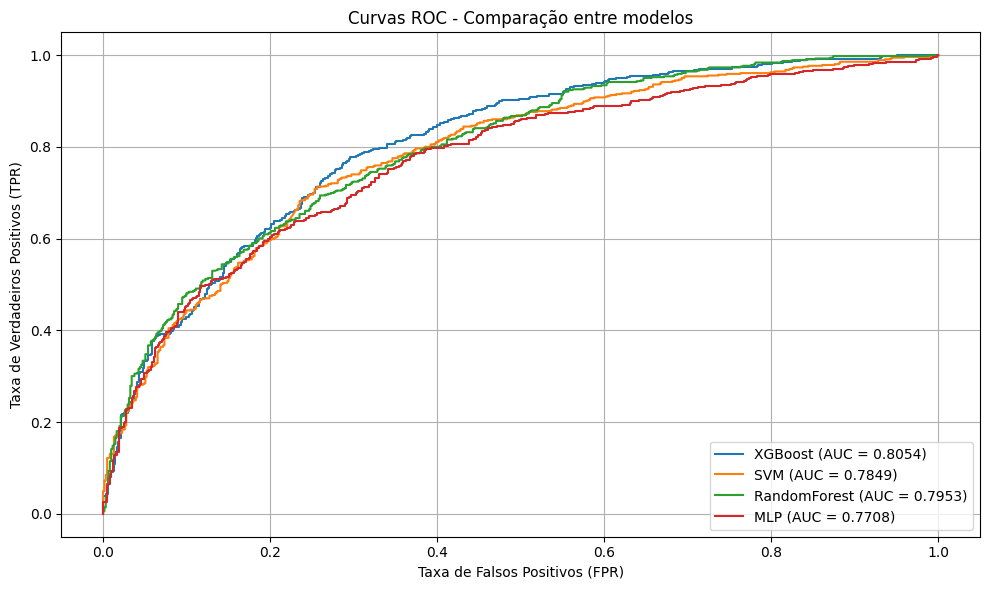

In [3]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Caminho base das imagens e tamanho padronizado
base_path = "infection/"
image_size = (64, 64)

# Montar dataset com caminhos das imagens e rótulos
dataset = []
for classe, label in zip(["Aug-Positive", "Aug-Negative"], [1, 0]):
    pasta = os.path.join(base_path, classe)
    for imagem in os.listdir(pasta):
        caminho_imagem = os.path.join(pasta, imagem)
        dataset.append((caminho_imagem, label))

df = pd.DataFrame(dataset, columns=["imagem", "label"])

# Função para carregar e normalizar imagens
def load_images(df, image_size):
    imagens = []
    labels = []
    for _, row in df.iterrows():
        img = cv2.imread(row["imagem"])
        if img is not None:
            img = cv2.resize(img, image_size)
            img = img.astype("float32") / 255.0  # Normalização
            img = img.flatten()
            imagens.append(img)
            labels.append(row["label"])
    return np.array(imagens), np.array(labels)

X, y = load_images(df, image_size)

# Inicializar estruturas para salvar métricas por modelo
modelos = {
    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=8,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=1,
        random_state=42,
        n_jobs=-1
    ),
    "SVM": SVC(
        kernel='rbf',
        C=1.0,
        probability=True,
        random_state=42
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    "MLP": MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    learning_rate_init=0.001,
    max_iter=500,
    early_stopping=True,
    random_state=42
)
}

resultados = {
    nome: {"acc": [], "prec": [], "rec": [], "f1": [], "auc": []}
    for nome in modelos
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    pca = PCA(n_components=50)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    for nome, modelo in modelos.items():
        modelo.fit(X_train_pca, y_train)
        y_pred = modelo.predict(X_test_pca)
        y_proba = modelo.predict_proba(X_test_pca)[:, 1]

        resultados[nome]["acc"].append(accuracy_score(y_test, y_pred))
        resultados[nome]["prec"].append(precision_score(y_test, y_pred))
        resultados[nome]["rec"].append(recall_score(y_test, y_pred))
        resultados[nome]["f1"].append(f1_score(y_test, y_pred))
        resultados[nome]["auc"].append(roc_auc_score(y_test, y_proba))


print("\n[MÉTRICAS FINAIS - MÉDIAS POR MODELO]")
for nome, metricas in resultados.items():
    print(f"\nModelo: {nome}")
    print(f"Acurácia:  {np.mean(metricas['acc']):.4f} ± {np.std(metricas['acc']):.4f}")
    print(f"Precisão:  {np.mean(metricas['prec']):.4f} ± {np.std(metricas['prec']):.4f}")
    print(f"Recall:    {np.mean(metricas['rec']):.4f} ± {np.std(metricas['rec']):.4f}")
    print(f"F1-Score:  {np.mean(metricas['f1']):.4f} ± {np.std(metricas['f1']):.4f}")
    print(f"AUC:       {np.mean(metricas['auc']):.4f} ± {np.std(metricas['auc']):.4f}")


# Redefinir os resultados para salvar as curvas ROC apenas de uma das divisões 
plt.figure(figsize=(10, 6))

for nome, modelo in modelos.items():
    y_proba = modelo.predict_proba(X_test_pca)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{nome} (AUC = {auc:.4f})")


plt.title("Curvas ROC - Comparação entre modelos")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()